# Text Classification with a Feed-forward Neural Network and BOW features

First, we will do some initialization.

In [1]:
import random
import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# enable tqdm in pandas
tqdm.pandas()

# set to True to use the gpu (if there is one available)
use_gpu = True

# select device
device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
print(f'device: {device.type}')

# random seed
seed = 1234

# set random seed
if seed is not None:
    print(f'random seed: {seed}')
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

device: cuda
random seed: 1234


We will be using the AG's News Topic Classification Dataset.
It is stored in two CSV files: `train.csv` and `test.csv`, as well as a `classes.txt` that stores the labels of the classes to predict.

First, we will load the training dataset using [pandas](https://pandas.pydata.org/) and take a quick look at how the data.

In [2]:
train_df = pd.read_csv('data/ag_news_csv/train.csv', header=None)
train_df.columns = ['class index', 'title', 'description']
train_df

,class index,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


The dataset consists of 120,000 examples, each consisting of a class index, a title, and a description.
The class labels are distributed in a separated file. We will add the labels to the dataset so that we can interpret the data more easily. Note that the label indexes are one-based, so we need to subtract one to retrieve them from the list.

In [3]:
labels = open('data/ag_news_csv/classes.txt').read().splitlines()
classes = train_df['class index'].map(lambda i: labels[i-1])
train_df.insert(1, 'class', classes)
train_df

,class index,class,title,description
0,3,Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,Business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...,...
119995,1,World,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Sports,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Sports,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Sports,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


Let's inspect how balanced our examples are by using a bar plot.

<AxesSubplot:>

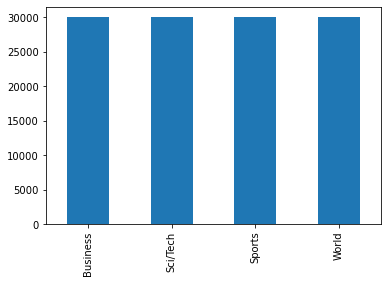

In [4]:
pd.value_counts(train_df['class']).plot.bar()

The classes are evenly distributed. That's great!

However, the text contains some spurious backslashes in some parts of the text.
They are meant to represent newlines in the original text.
An example can be seen below, between the words "dwindling" and "band".

In [5]:
print(train_df.loc[0, 'description'])

Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


We will replace the backslashes with spaces on the whole column using pandas replace method.

In [6]:
train_df['text'] = train_df['title'].str.lower() + " " + train_df['description'].str.lower()
train_df['text'] = train_df['text'].str.replace('\\', ' ', regex=False)
train_df

,class index,class,title,description,text
0,3,Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",wall st. bears claw back into the black (reute...
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,carlyle looks toward commercial aerospace (reu...
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,oil and economy cloud stocks' outlook (reuters...
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,iraq halts oil exports from main southern pipe...
4,3,Business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","oil prices soar to all-time record, posing new..."
...,...,...,...,...,...
119995,1,World,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...,pakistan's musharraf says won't quit as army c...
119996,2,Sports,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...,renteria signing a top-shelf deal red sox gene...
119997,2,Sports,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...,saban not going to dolphins yet the miami dolp...
119998,2,Sports,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...,today's nfl games pittsburgh at ny giants time...


Now we will proceed to tokenize the title and description columns using NLTK's word_tokenize().
We will add a new column to our dataframe with the list of tokens.

In [7]:
from nltk.tokenize import word_tokenize

train_df['tokens'] = train_df['text'].progress_map(word_tokenize)
train_df

  0%|          | 0/120000 [00:00<?, ?it/s]

,class index,class,title,description,text,tokens
0,3,Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",wall st. bears claw back into the black (reute...,"[wall, st., bears, claw, back, into, the, blac..."
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,carlyle looks toward commercial aerospace (reu...,"[carlyle, looks, toward, commercial, aerospace..."
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,oil and economy cloud stocks' outlook (reuters...,"[oil, and, economy, cloud, stocks, ', outlook,..."
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,iraq halts oil exports from main southern pipe...,"[iraq, halts, oil, exports, from, main, southe..."
4,3,Business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","oil prices soar to all-time record, posing new...","[oil, prices, soar, to, all-time, record, ,, p..."
...,...,...,...,...,...,...
119995,1,World,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...,pakistan's musharraf says won't quit as army c...,"[pakistan, 's, musharraf, says, wo, n't, quit,..."
119996,2,Sports,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...,renteria signing a top-shelf deal red sox gene...,"[renteria, signing, a, top-shelf, deal, red, s..."
119997,2,Sports,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...,saban not going to dolphins yet the miami dolp...,"[saban, not, going, to, dolphins, yet, the, mi..."
119998,2,Sports,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...,today's nfl games pittsburgh at ny giants time...,"[today, 's, nfl, games, pittsburgh, at, ny, gi..."


In [8]:
from sklearn.model_selection import train_test_split

train_df, dev_df = train_test_split(train_df, train_size=0.8)
train_df.reset_index(inplace=True)
dev_df.reset_index(inplace=True)

print(f'train rows: {len(train_df.index):,}')
print(f'dev rows: {len(dev_df.index):,}')

train rows: 96,000
dev rows: 24,000


Now we will create a vocabulary from the training data. We will only keep the terms that repeat beyond some threshold established below.

In [9]:
threshold = 10
tokens = train_df['tokens'].explode().value_counts()
tokens = tokens[tokens > threshold]
id_to_token = ['[UNK]'] + tokens.index.tolist()
token_to_id = {w:i for i,w in enumerate(id_to_token)}
vocabulary_size = len(id_to_token)
print(f'vocabulary size: {vocabulary_size:,}')

vocabulary size: 17,447


In [10]:
from collections import defaultdict

def make_feature_vector(tokens, unk_id=0):
    vector = defaultdict(int)
    for t in tokens:
        i = token_to_id.get(t, unk_id)
        vector[i] += 1
    return vector

train_df['features'] = train_df['tokens'].progress_map(make_feature_vector)
dev_df['features'] = dev_df['tokens'].progress_map(make_feature_vector)
train_df

  0%|          | 0/96000 [00:00<?, ?it/s]

  0%|          | 0/24000 [00:00<?, ?it/s]

,index,class index,class,title,description,text,tokens,features
0,9116,1,World,Najaf's Residents Feel Trapped in Battle (AP),"AP - For nearly three weeks, Amer al-Jamali ha...",najaf's residents feel trapped in battle (ap) ...,"[najaf, 's, residents, feel, trapped, in, batt...","{994: 1, 23: 2, 1733: 1, 2998: 1, 3970: 1, 7: ..."
1,99831,3,Business,U.S. FDA Adds Restrictions to Acne Drug,WASHINGTON (Reuters) - Roche's acne drug Accu...,u.s. fda adds restrictions to acne drug washi...,"[u.s., fda, adds, restrictions, to, acne, drug...","{70: 2, 2501: 1, 1686: 1, 5733: 1, 4: 3, 0: 4,..."
2,10663,3,Business,Smithfield Foods Profit More Than Doubles,"Smithfield Foods Inc. (SFD.N: Quote, Profile, ...",smithfield foods profit more than doubles smit...,"[smithfield, foods, profit, more, than, double...","{8589: 2, 2690: 3, 157: 1, 54: 2, 78: 2, 3145:..."
3,73175,4,Sci/Tech,PluggedIn: The OQO Is Not Just Another Handhel...,SAN FRANCISCO (Reuters) - A full-fledged Wind...,pluggedin: the oqo is not just another handhel...,"[pluggedin, :, the, oqo, is, not, just, anothe...","{11371: 1, 28: 1, 1: 6, 15716: 2, 25: 1, 68: 1..."
4,104494,4,Sci/Tech,IBM invigorates LTO tape storage,LTO (linear tape open)-based drives are invigo...,ibm invigorates lto tape storage lto (linear t...,"[ibm, invigorates, lto, tape, storage, lto, (,...","{210: 2, 0: 7, 3000: 3, 990: 2, 14: 1, 154: 1,..."
...,...,...,...,...,...,...,...,...
95995,89460,1,World,"Bush, Blair See Hope for Palestinian State (AP)","AP - As Yasser Arafat was buried, President Bu...","bush, blair see hope for palestinian state (ap...","[bush, ,, blair, see, hope, for, palestinian, ...","{135: 2, 2: 3, 765: 1, 672: 1, 886: 1, 11: 2, ..."
95996,60620,1,World,Ex-Soldiers Vow to Bring Order to Haiti Capital,Ex-soldiers who helped topple former President...,ex-soldiers vow to bring order to haiti capita...,"[ex-soldiers, vow, to, bring, order, to, haiti...","{14086: 2, 6460: 1, 4: 3, 1042: 1, 1078: 1, 13..."
95997,34086,1,World,Musharraf says U.S. must address root of terro...,Reuters - The United States could lose its war...,musharraf says u.s. must address root of terro...,"[musharraf, says, u.s., must, address, root, o...","{1627: 2, 91: 1, 70: 1, 752: 1, 2353: 1, 8685:..."
95998,58067,1,World,Nuclear materials #39;vanish #39; in Iraq,Equipment and materials that could be used to ...,nuclear materials #39;vanish #39; in iraq equ...,"[nuclear, materials, #, 39, ;, vanish, #, 39, ...","{275: 2, 3413: 2, 12: 3, 13: 3, 8: 3, 12090: 1..."


In [11]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        x = torch.zeros(vocabulary_size, dtype=torch.float32)
        y = torch.tensor(self.y[index])
        for k,v in self.x[index].items():
            x[k] = v
        return x, y

In [12]:
from torch import nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim),
        )
        
    def forward(self, x):
        return self.layers(x)

In [13]:
from torch import optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

# hyperparameters
lr = 1e-3
weight_decay = 1e-5
batch_size = 500
shuffle = True
n_epochs = 5
input_dim = vocabulary_size
hidden_dim = 50
output_dim = len(labels)
dropout = 0.3

# initialize the model, loss function, optimizer, and data-loader
model = Model(input_dim, hidden_dim, output_dim, dropout).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay)
train_ds = MyDataset(
    train_df['features'],
    train_df['class index'] - 1)
train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=shuffle)
dev_ds = MyDataset(
    dev_df['features'],
    dev_df['class index'] - 1)
dev_dl = DataLoader(
    dev_ds,
    batch_size=batch_size,
    shuffle=shuffle)

# lists used to store plotting data
train_loss, train_acc = [], []
dev_loss, dev_acc = [], []

In [14]:
# train the model
for epoch in range(n_epochs):
    losses, acc = [], []
    # set model to training mode
    model.train()
    for X, y_true in tqdm(train_dl, desc=f'epoch {epoch+1} (train)'):
        # clear gradients
        model.zero_grad()
        # send batch to right device
        X = X.to(device)
        y_true = y_true.to(device)
        # predict label scores
        y_pred = model(X)
        # compute loss
        loss = loss_func(y_pred, y_true)
        # compute accuracy
        gold = y_true.detach().cpu().numpy()
        pred = np.argmax(y_pred.detach().cpu().numpy(), axis=1)
        # accumulate for plotting
        losses.append(loss.detach().cpu().item())
        acc.append(accuracy_score(gold, pred))
        # backpropagate
        loss.backward()
        # optimize model parameters
        optimizer.step()
    # save epoch stats
    train_loss.append(np.mean(losses))
    train_acc.append(np.mean(acc))
    
    # set model to evaluation mode
    model.eval()
    # disable gradient calculation
    with torch.no_grad():
        losses, acc = [], []
        for X, y_true in tqdm(dev_dl, desc=f'epoch {epoch+1} (dev)'):
            # send batch to right device
            X = X.to(device)
            y_true = y_true.to(device)
            # predict label scores
            y_pred = model(X)
            # compute loss
            loss = loss_func(y_pred, y_true)
            # compute accuracy
            gold = y_true.cpu().numpy()
            pred = np.argmax(y_pred.cpu().numpy(), axis=1)
            # accumulate for plotting
            losses.append(loss.cpu().item())
            acc.append(accuracy_score(gold, pred))
        # save epoch stats
        dev_loss.append(np.mean(losses))
        dev_acc.append(np.mean(acc))

epoch 1 (train):   0%|          | 0/192 [00:00<?, ?it/s]

epoch 1 (dev):   0%|          | 0/48 [00:00<?, ?it/s]

epoch 2 (train):   0%|          | 0/192 [00:00<?, ?it/s]

epoch 2 (dev):   0%|          | 0/48 [00:00<?, ?it/s]

epoch 3 (train):   0%|          | 0/192 [00:00<?, ?it/s]

epoch 3 (dev):   0%|          | 0/48 [00:00<?, ?it/s]

epoch 4 (train):   0%|          | 0/192 [00:00<?, ?it/s]

epoch 4 (dev):   0%|          | 0/48 [00:00<?, ?it/s]

epoch 5 (train):   0%|          | 0/192 [00:00<?, ?it/s]

epoch 5 (dev):   0%|          | 0/48 [00:00<?, ?it/s]

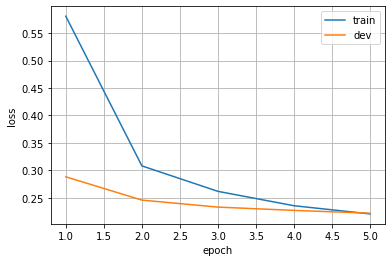

In [15]:
import matplotlib.pyplot as plt

x = np.arange(n_epochs) + 1

plt.plot(x, train_loss)
plt.plot(x, dev_loss)
plt.legend(['train', 'dev'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)

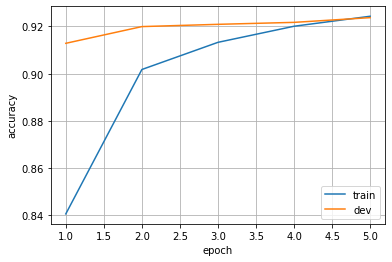

In [16]:
plt.plot(x, train_acc)
plt.plot(x, dev_acc)
plt.legend(['train', 'dev'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)

## Evaluate on test dataset

In [17]:
# repeat all preprocessing done above, this time on the test set
test_df = pd.read_csv('data/ag_news_csv/test.csv', header=None)
test_df.columns = ['class index', 'title', 'description']
test_df['text'] = test_df['title'].str.lower() + " " + test_df['description'].str.lower()
test_df['text'] = test_df['text'].str.replace('\\', ' ', regex=False)
test_df['tokens'] = test_df['text'].progress_map(word_tokenize)
test_df['features'] = test_df['tokens'].progress_map(make_feature_vector)
test_df

  0%|          | 0/7600 [00:00<?, ?it/s]

  0%|          | 0/7600 [00:00<?, ?it/s]

,class index,title,description,text,tokens,features
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...,fears for t n pension after talks unions repre...,"[fears, for, t, n, pension, after, talks, unio...","{849: 1, 11: 1, 150: 1, 5528: 1, 1487: 1, 38: ..."
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o...",the race is on: second private team sets launc...,"[the, race, is, on, :, second, private, team, ...","{1: 3, 489: 1, 25: 1, 10: 1, 28: 1, 134: 2, 90..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...,ky. company wins grant to study peptides (ap) ...,"[ky., company, wins, grant, to, study, peptide...","{11865: 1, 60: 2, 409: 1, 4371: 2, 4: 2, 499: ..."
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...,prediction unit helps forecast wildfires (ap) ...,"[prediction, unit, helps, forecast, wildfires,...","{9309: 1, 611: 1, 1998: 1, 710: 1, 0: 4, 14: 1..."
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...,calif. aims to limit farm-related smog (ap) ap...,"[calif., aims, to, limit, farm-related, smog, ...","{1052: 1, 1761: 1, 4: 2, 3195: 1, 0: 4, 13330:..."
...,...,...,...,...,...,...
7595,1,Around the world,Ukrainian presidential candidate Viktor Yushch...,around the world ukrainian presidential candid...,"[around, the, world, ukrainian, presidential, ...","{432: 1, 1: 2, 58: 1, 4318: 1, 388: 1, 1396: 1..."
7596,2,Void is filled with Clement,With the supply of attractive pitching options...,void is filled with clement with the supply of...,"[void, is, filled, with, clement, with, the, s...","{9333: 1, 25: 1, 5215: 1, 19: 3, 10874: 2, 1: ..."
7597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...,martinez leaves bitter like roger clemens did ...,"[martinez, leaves, bitter, like, roger, clemen...","{1975: 2, 1898: 1, 3122: 2, 312: 1, 1671: 1, 3..."
7598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...,5 of arthritis patients in singapore take bext...,"[5, of, arthritis, patients, in, singapore, ta...","{621: 1, 6: 1, 2727: 1, 2441: 1, 7: 2, 1065: 2..."


In [18]:
from sklearn.metrics import classification_report

# set model to evaluation mode
model.eval()

dataset = MyDataset(test_df['features'], test_df['class index'] - 1)
data_loader = DataLoader(dataset, batch_size=batch_size)
y_pred = []

# disable gradient calculation
with torch.no_grad():
    for X, _ in tqdm(data_loader):
        X = X.to(device)
        # predict one class per example
        y = torch.argmax(model(X), dim=1)
        # convert tensor to numpy array
        y_pred.append(y.cpu().numpy())
    
# print results
y_true = dataset.y
y_pred = np.concatenate(y_pred)
print(classification_report(y_true, y_pred, target_names=labels))

  0%|          | 0/16 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       World       0.94      0.90      0.92      1900
      Sports       0.96      0.99      0.97      1900
    Business       0.89      0.88      0.89      1900
    Sci/Tech       0.89      0.90      0.89      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600



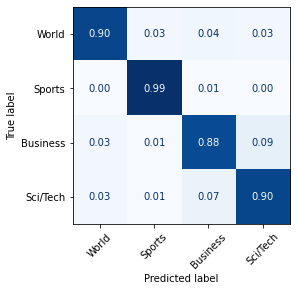

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(cmap='Blues', values_format='.2f', colorbar=False, ax=ax, xticks_rotation=45)